# Verify Hypothesis

In [189]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import MeCab

DATA_FILE = "./data/qiita_prediction.tsv"
DICT_PATH = "/usr/local/Cellar/mecab/0.996/lib/mecab/dic/mecab-ipadic-neologd"

# read data to dataframe
qiita_posts = pd.read_table(DATA_FILE, header=0, names=["judge", "title", "headline", "good", "url"])
qiita_posts.drop("url", axis=1, inplace=True)
print("{} records.".format(qiita_posts.shape[0]))
qiita_posts.head(5)

100 records.


,judge,title,headline,good
0,0,[めも]pixi.jsでキーボードイベント,参考になれば。,0
1,0,flowの始め方,ということで、前回に引き続きReact Confで紹介されてたものを試すシリーズの第二回です...,0
2,1,Chainer で Hello World!,Chainer は、Preferred Networks が提供するニューラルネットワーク向...,1
3,0,fastTextの学習済みモデルをPythonから使う,gensim が提供しているラッパーが使える。,2
4,0,PythonでGPSモジュールから10Hzでデータを取得する,gpsdを使わない、シリアル接続でのGPS10Hz化です。 コードは以下の通りで、一番下のメ...,2


In [245]:
import re
# parse sentences

parser = MeCab.Tagger("-Ochasen -d " + DICT_PATH)
def parse_sentence(s):
    _s = s.strip()
    tokens = parser.parseToNode(_s)
    nouns = []
    n = ""
    while tokens:
        try:
            w = tokens.surface
            if len(w) > 1 and "固有名詞" in tokens.feature:
                n += w
            elif len(n) > 0:
                nouns.append(n)
                n = ""
        except UnicodeDecodeError as ex:
            pass
        tokens = tokens.next
        
    return nouns


def split_sentence(s):
    sentences = re.split("．|。|\!|\?|\！|\？|", s)
    return [s for s in sentences if len(s) > 1]


def parse_section(h):
    sentences = split_sentence(h)
    tokens = [parse_sentence(s) for s in sentences]
    return tokens
    
qiita_posts["title_ts"] = qiita_posts["title"].apply(parse_sentence)
qiita_posts["headline_ss"] = qiita_posts["headline"].apply(split_sentence)
qiita_posts["headline_ts"] = qiita_posts["headline"].apply(parse_section)

qiita_posts[["title_ts", "headline_ss", "headline_ts"]].head(3)

/Users/smap6/.pyenv/versions/miniconda3-3.9.1/envs/nlp/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


,title_ts,headline_ss,headline_ts
0,[],[参考になれば],[[]]
1,[flow],[ということで、前回に引き続きReact Confで紹介されてたものを試すシリーズの第二回で...,"[[React], [flow, eslint, babel, precommit, vim..."
2,"[Chainer, HelloWorld]",[Chainer は、Preferred Networks が提供するニューラルネットワーク...,"[[Chainer, Preferred Networks, ニューラルネットワーク, 機械..."


In [222]:
from functools import reduce
# make feature

def match(r):
    title_tokens = r["title_ts"]
    head_tokens = reduce(lambda a, b: a + b, r["headline_ts"])[:3]
    count = 0
    for t in title_tokens:
        if t in head_tokens:
            count += 1
    return count

def word_chain(sentences_tokens):
    prev = []
    chains = []
    for st in sentences_tokens:
        if len(prev) > 0:
            i = 0
            for t in st:
                if t in prev:
                    i += 1
            chains.append(i)
        prev = st
    if len(chains) > 0:
        return np.mean(chains)
    else:
        return 0

def sentence_difficulty(sentences_tokens):
    score = 0
    for st in sentences_tokens:
        if len(st) > 3:
            score += 1
        elif len(st) == 0:
            score += 1
        else:
            score -= 1
    return score

def definition_desc(r):
    heads = r["headline_ss"]
    head_tokens = r["headline_ts"]
    score = 0
    for i, s in enumerate(heads):
        if len(head_tokens[i]) > 0 and s.startswith(head_tokens[i][0]):
            score += 1
    return score

def ng_words(sentences):
    score = 0
    ngs = ["する。", "できた", "個人", "とのこと", "みた。", "書きかけ", "メモ", "勉強がてら", "今回は", "みました。", "とか。", "駄文"]
    for s in sentences:
        score += sum([0 if n not in s else -1 for n in ngs])
    return score

def pg_words(sentences):
    score = 0
    pgs = ["そこで", "という方", "方を", "方に", "向け", "るように","ので、", "説明し"]
    for s in sentences:
        score += sum([0 if p not in s else 1 for p in pgs])
    return score

def sentence_sep_rate(sentences):
    sep_rates = np.mean([len(s.split("、")) / len(s) for s in sentences])
    return sep_rates
    

qiita_label = qiita_posts["judge"]
qiita_feature = pd.DataFrame()
qiita_feature["good"] = qiita_posts["good"]
qiita_feature["s_length_mean"] = qiita_posts["headline_ss"].apply(lambda ss: np.mean([len(s) for s in ss]))
qiita_feature["s_length_max"] = qiita_posts["headline_ss"].apply(lambda ss: np.max([len(s) for s in ss]))
qiita_feature["s_length_min"] = qiita_posts["headline_ss"].apply(lambda ss: np.min([len(s) for s in ss]))
qiita_feature["ts_mean"] = qiita_posts["headline_ts"].apply(lambda ts: np.mean([len(t) for t in ts]))
qiita_feature["ts_max"] = qiita_posts["headline_ts"].apply(lambda ts: np.max([len(t) for t in ts]))
qiita_feature["ts_min"] = qiita_posts["headline_ts"].apply(lambda ts: np.min([len(t) for t in ts]))
qiita_feature["title_match"] = qiita_posts.apply(match, axis=1)
qiita_feature["word_chain"] = qiita_posts["headline_ts"].apply(word_chain)
qiita_feature["s_difficulty"] = qiita_posts["headline_ts"].apply(sentence_difficulty)
qiita_feature["ng_words"] = qiita_posts["headline_ss"].apply(ng_words)
qiita_feature["pg_words"] = qiita_posts["headline_ss"].apply(pg_words)
qiita_feature["sentence_sep_rate"] = qiita_posts["headline_ss"].apply(sentence_sep_rate)

qiita_feature.head(5)

,good,s_length_mean,s_length_max,s_length_min,ts_mean,ts_max,ts_min,title_match,word_chain,s_difficulty,ng_words,pg_words,sentence_sep_rate
0,0,6.000000,6,6,0.000000,0,0,0,0.0,1,0,0,0.166667
1,0,28.166667,50,6,1.166667,5,0,1,0.0,2,0,0,0.069177
2,1,39.500000,61,16,1.750000,4,0,1,0.0,0,0,2,0.052750
3,2,22.000000,22,22,2.000000,2,2,0,0.0,-1,0,0,0.045455
4,2,35.500000,43,28,0.500000,1,0,1,0.0,0,0,0,0.058970


In [223]:
# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
qiita_feature_n = scaler.fit_transform(qiita_feature)

[ 0.53333333  0.54545455  0.25        0.22222222  0.52173913]
             precision    recall  f1-score   support

        bad       0.69      0.82      0.75        11
       good       0.71      0.56      0.63         9

avg / total       0.70      0.70      0.69        20



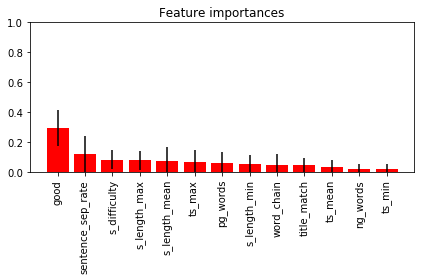

In [243]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# estimate accuracy by cross validation
clf = RandomForestClassifier(n_estimators=15, max_features=0.5)
scores = cross_val_score(clf, qiita_feature_n, qiita_label, cv=5, scoring="f1")
print(scores)

# train and show score
train_f, test_f, train_lb, test_lb = train_test_split(qiita_feature_n, qiita_label, test_size=0.2, random_state=42)
clf.fit(train_f, train_lb)
pred = clf.predict(test_f)
print(classification_report(test_lb, pred, target_names=["bad", "good"]))

# show feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
labels = np.array(qiita_feature.columns.values.tolist())
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(labels)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(labels)), labels[indices], rotation="vertical")
plt.xlim([-1, len(labels)])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()